# Import the Required Modules

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import tkinter as tk
from tkinter import ttk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

2023-05-12 19:50:14.730702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare the Data

In [2]:
# Extract the dataset
data_dir = pathlib.Path("galaxy_images")

# Convert the data_dir path to a Path object
data_dir = pathlib.Path(data_dir)

In [3]:
# Print the path to the dataset directory
print("Dataset directory:", data_dir)

Dataset directory: galaxy_images


In [4]:
# Get a list of file paths for images in the 'spiral' directory
spiral = list(data_dir.glob('spiral/*'))

# Print the path of the first image
print(spiral[0])

# Open the first image using PIL
PIL.Image.open(str(spiral[0]))
import tensorflow as tf

galaxy_images/spiral/spiral galaxy_60.jpg


# Preprocess the Dataset

In [5]:
# Set the desired height and width for the images
img_height, img_width = 180, 180

# Set the batch size for training
batch_size = 32

# Create an instance of ImageDataGenerator for data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2
)

# Load and preprocess the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get the class names from the training dataset
class_names = train_ds.class_names

# Convert labels to integer data type
train_ds = train_ds.map(lambda x, y: (x, tf.cast(y, dtype=tf.int32)))

# Apply one-hot encoding to the labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))

# Prefetch the dataset to optimize data loading
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 240 files belonging to 3 classes.
Using 192 files for training.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-12 19:50:25.392184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load and preprocess the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Convert class names to numerical labels
label_map = {class_name: i for i, class_name in enumerate(val_ds.class_names)}

# Apply one-hot encoding to the labels
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, len(val_ds.class_names))))


Found 240 files belonging to 3 classes.
Using 48 files for validation.


In [7]:
# Convert data_dir to a Path object for easier manipulation
data_dir = pathlib.Path(data_dir)

# Directories to exclude from the class names
exclude_dirs = ['.DS_Store']

# Get the class names by filtering the directories in the data directory
class_names = [name for name in os.listdir(data_dir) if os.path.isdir(data_dir / name) and name not in exclude_dirs]

print(class_names)

['irregular', 'spiral', 'elliptical']


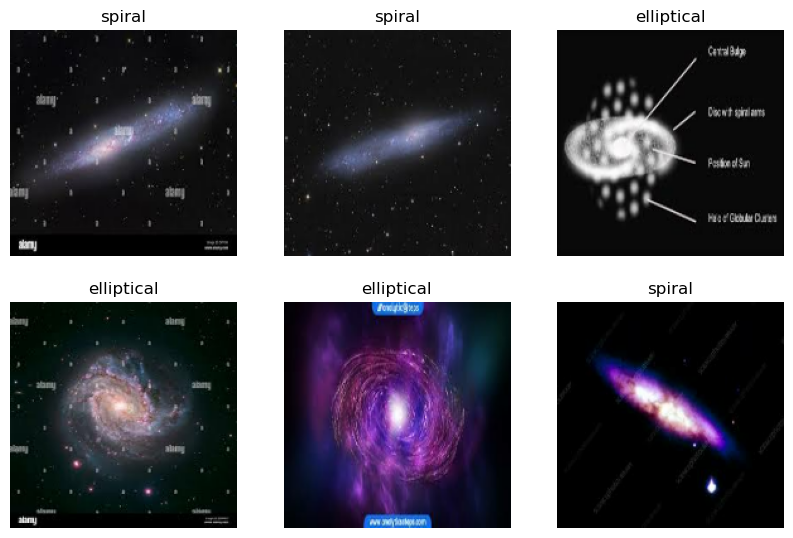

In [8]:
# Create a figure to display the images
plt.figure(figsize=(10, 10))

# Iterate over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Iterate over a subset of images in the batch
    for i in range(6):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Get the index of the predicted class for the current image
        label_index = tf.argmax(labels[i])
        
        # Get the class name corresponding to the predicted class index
        class_name = class_names[label_index]
        
        # Set the title of the subplot to the class name
        plt.title(class_name)
        
        # Disable the axis labels
        plt.axis("off")

# Train the CNN Model

In [9]:
# Create a new sequential model
resnet_model = Sequential()

# Load the pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180, 180, 3),
    pooling='avg',
    classes=5,
    weights='imagenet'
)

# Set all layers of the pre-trained model as non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the sequential model
resnet_model.add(pretrained_model)

# Add a Flatten layer to convert the output into a 1D tensor
resnet_model.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation
resnet_model.add(Dense(512, activation='relu'))

# Add a Dropout layer after the dense layers
resnet_model.add(layers.Dropout(0.5))

# Add the final Dense layer with the number of classes as units and softmax activation
resnet_model.add(Dense(len(class_names), activation='softmax'))

In [10]:
# Print a summary of the model architecture
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Compile the model with specified optimiser, loss function, and metrics
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
# Number of training epochs
epochs = 2

# Fit the model to the training data and validate it on the validation data
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Get the average accuracy score from the training history
average_accuracy = np.mean(history.history['accuracy'])

Epoch 1/2
6/6 [==============================] - 19s 3s/step - loss: 2.6151 - accuracy: 0.4115 - val_loss: 1.3908 - val_accuracy: 0.6250
Epoch 2/2
6/6 [==============================] - 15s 3s/step - loss: 1.2626 - accuracy: 0.6771 - val_loss: 0.8798 - val_accuracy: 0.7083


# Evaluate the CNN Model

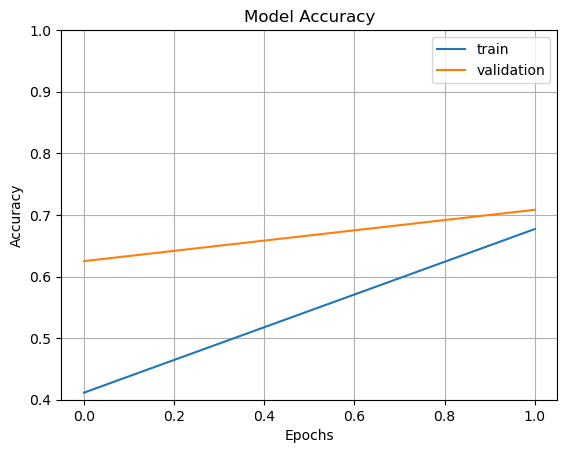

In [13]:
# Get the current figure
fig1 = plt.gcf()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Set the y-axis limits
plt.axis(ymin=0.4, ymax=1)

# Add a grid to the plot
plt.grid()

# Set the title and axis labels
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Add a legend to the plot
plt.legend(['train', 'validation'])

# Display the plot
plt.show()

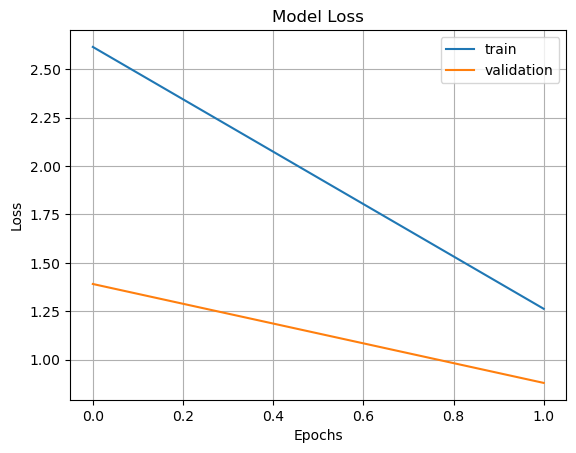

In [14]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Add a grid to the plot
plt.grid()

# Set the title and axis labels
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Add a legend to the plot
plt.legend(['train', 'validation'])

# Display the plot
plt.show()

# Make Predictions

In [15]:
# Read the image using OpenCV
image = cv2.imread(str(spiral[0]))

# Check if the image was read successfully
if image is not None:
    # Resize the image to the desired height and width
    image_resized = cv2.resize(image, (img_height, img_width))

    # Check if the resized image has the desired shape
    if image_resized.shape[:2] == (img_height, img_width):
        # Expand the dimensions of the image to match the expected input shape of the model
        image = np.expand_dims(image_resized, axis=0)

        # Print the shape of the image
        print(image.shape)
    else:
        print("Incompatible image shape after resizing.")
else:
    print("Failed to read image.")

(1, 180, 180, 3)


In [16]:
# Make predictions on the image using the trained model
pred = resnet_model.predict(image)

# Print the prediction results
print(pred)

1/1 [==============================] - 1s 821ms/step
[[0.00353499 0.6312537  0.36521134]]


In [17]:
# Retrieve the predicted class name using the index from the class_names list
output_class=class_names[np.argmax(pred)]

# Print the predicted class
print("The predicted class is", output_class)

The predicted class is spiral


# Train a Decision Tree Model

In [18]:
# Convert the training dataset to numpy arrays
X = []
y = []
for images, labels in train_ds:
    images = images.numpy()
    labels = labels.numpy()
    X.append(images)
    y.append(labels)

X = np.concatenate(X)
y = np.concatenate(y)
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create a decision tree classifier
tree = DecisionTreeClassifier()

# Train the classifier
tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree.predict(X_test)

# Convert y_test and y_pred to their original label format
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Decision Tree Model

Accuracy: 0.4358974358974359
Precision: 0.4943043884220355
Recall: 0.4426282051282051
F1 Score: 0.43416915880684


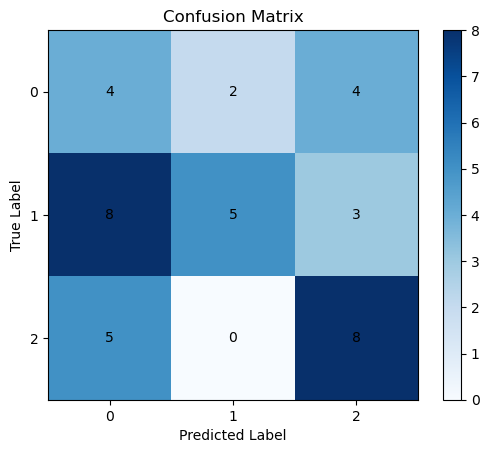

In [19]:
# Evaluate the model
accuracy = metrics.accuracy_score(y_test_labels, y_pred_labels)
precision = metrics.precision_score(y_test_labels, y_pred_labels, average='macro')
recall = metrics.recall_score(y_test_labels, y_pred_labels, average='macro')
f1_score = metrics.f1_score(y_test_labels, y_pred_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Create a confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()

# Add label annotations to the plot
categories = np.unique(y_test_labels)
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories)
plt.yticks(tick_marks, categories)

# Add counts to the plot
for i in range(len(categories)):
    for j in range(len(categories)):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center')

plt.show()

# Combine the CNN and Decision Tree Models

In [20]:
# Preprocess and resize the test images
X_test_preprocessed = []
for image in X_test:
    image_resized = cv2.resize(image, (img_height, img_width))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    X_test_preprocessed.append(image_rgb)

# Convert the preprocessed images to a numpy array
X_test_preprocessed = np.array(X_test_preprocessed)

# Reshape X_test_preprocessed to 2D array
X_test_flattened = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], -1)

# Make predictions on the preprocessed test images using the decision tree model
y_pred_decision_tree = tree.predict(X_test_flattened)

# Make predictions on the preprocessed test images using the neural network model
nn_predictions = resnet_model.predict(X_test_preprocessed)

# Combine the predictions of the decision tree and neural network models
combined_predictions = []

for i in range(len(y_pred_decision_tree)):
    decision_tree_vote = np.argmax(y_pred_decision_tree[i])
    neural_network_vote = np.argmax(nn_predictions[i])

    if decision_tree_vote == neural_network_vote:
        combined_predictions.append(decision_tree_vote)
    else:
        indices = [decision_tree_vote, neural_network_vote]
        combined_vote = np.random.choice(indices)
        combined_predictions.append(combined_vote)

combined_predictions = np.array(combined_predictions)

# Define the number of classes in your dataset
num_classes = 3

# Convert combined_predictions to multilabel-indicator format
combined_predictions_categorical = to_categorical(combined_predictions, num_classes=num_classes)

2/2 [==============================] - 3s 409ms/step


# Evaluate the Combined Model

Decision Tree Accuracy: 0.41025641025641024
Combined Model Accuracy: 0.358974358974359
CNN Average Accuracy: 0.5442708283662796


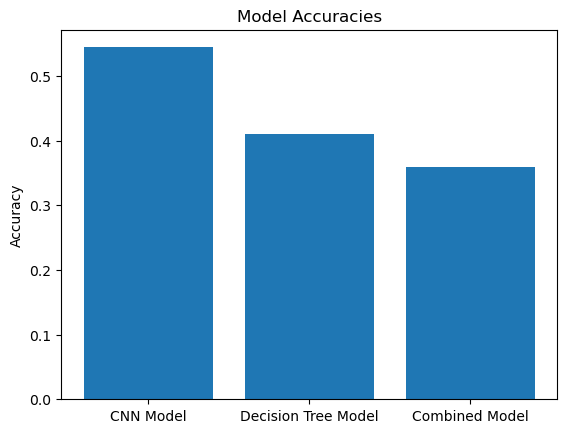

In [21]:
# Evaluate the decision tree model
accuracy_decision_tree = metrics.accuracy_score(y_test, y_pred_decision_tree)
print("Decision Tree Accuracy:", accuracy_decision_tree)

# Evaluate the performance of the combined model
combined_accuracy = metrics.accuracy_score(y_test, combined_predictions_categorical)
print("Combined Model Accuracy:", combined_accuracy)

# Get the average accuracy score from the previously trained model
average_accuracy_cnn = np.mean(history.history['accuracy'])
print("CNN Average Accuracy:", average_accuracy_cnn)

# Plot the accuracies
labels = ['CNN Model', 'Decision Tree Model', 'Combined Model']
accuracies = [average_accuracy_cnn, accuracy_decision_tree, combined_accuracy]

plt.bar(labels, accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.show()

# Custom Tune the CNN Model (GUI)

In [ ]:
# Create a Tkinter window
window = tk.Tk()
window.title("CNN Model Hyperparameter Tuning")

# Define the function to update the model with the selected hyperparameters
def update_model(resnet_model):
    global accuracy_plot, accuracy_canvas, bar_chart, bar_chart_canvas

    epochs = int(epochs_entry.get())
    learning_rate = float(learning_rate_entry.get())

    # Clear the previous accuracy plot
    accuracy_plot.clear()

    # Update the model with the new hyperparameters and retrain
    if resnet_model is not None:
        resnet_model.compile(optimizer=Adam(learning_rate=learning_rate),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

        # Lists to store the accuracy data for each epoch
        train_accuracy = []
        val_accuracy = []

        for epoch in range(epochs):
            history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=1)

            # Append the accuracy for the current epoch
            train_accuracy.append(history.history['accuracy'][0])
            val_accuracy.append(history.history['val_accuracy'][0])

        # Plot the accuracy data for all epochs
        accuracy_plot.plot(train_accuracy, color='blue', label='Train')
        accuracy_plot.plot(val_accuracy, color='orange', label='Validation')
        accuracy_plot.set_ylim([0, 1])
        accuracy_plot.set_title('Model Accuracy')
        accuracy_plot.set_ylabel('Accuracy')
        accuracy_plot.set_xlabel('Epochs')

        # Update the plot canvas
        accuracy_canvas.draw()

        # Calculate the average accuracy of the tuned model
        tuned_average_accuracy = np.mean(history.history['accuracy'])

        # Update the bar chart
        bar_chart.clear()
        bar_chart.bar(['Default CNN Model', 'Tuned CNN Model'], [default_accuracy, tuned_average_accuracy])
        bar_chart.set_ylim([0, 1])
        bar_chart.set_title('Average Accuracy')
        bar_chart.set_ylabel('Accuracy')

        # Update the bar chart canvas
        bar_chart_canvas.draw()

# Define a separate function to capture the value of `resnet_model`
def handle_update():
    update_model(resnet_model)

# Create a label and entry for the number of epochs
epochs_label = ttk.Label(window, text="Number of Epochs:")
epochs_label.pack()
epochs_entry = ttk.Entry(window)
epochs_entry.insert(tk.END, "10") 
epochs_entry.pack()

# Create a label and entry for the learning rate
learning_rate_label = ttk.Label(window, text="Learning Rate:")
learning_rate_label.pack()
learning_rate_entry = ttk.Entry(window)
learning_rate_entry.insert(tk.END, "0.001")
learning_rate_entry.pack()

# Create a button to update the model
update_button = ttk.Button(window, text="Tune Model", command=handle_update)
update_button.pack()

# Create a figure for the accuracy plot
accuracy_figure = Figure(figsize=(6, 4))
accuracy_plot = accuracy_figure.add_subplot(111)

# Create a Tkinter canvas for the accuracy plot
accuracy_canvas = FigureCanvasTkAgg(accuracy_figure, master=window)
accuracy_canvas.get_tk_widget().pack()

# Set the labels for the accuracy plot
accuracy_plot.set_title('Model Accuracy')
accuracy_plot.set_ylabel('Accuracy')
accuracy_plot.set_xlabel('Epochs')

# Get the average accuracy score from the training history of the default model
default_accuracy = np.mean(history.history['accuracy'])

# Create a figure for the bar chart
bar_chart_figure = Figure(figsize=(6, 4))
bar_chart = bar_chart_figure.add_subplot(111)

# Create a Tkinter canvas for the bar chart
bar_chart_canvas = FigureCanvasTkAgg(bar_chart_figure, master=window)
bar_chart_canvas.get_tk_widget().pack()

# Set the labels for the bar chart
bar_chart.set_title('Average Accuracy')
bar_chart.set_ylabel('Accuracy')

# Update the bar chart with initial data
bar_chart.bar(['Default CNN Model'], [default_accuracy])
bar_chart.set_ylim([0, 1])

# Update the bar chart canvas
bar_chart_canvas.draw()

# Display the GUI elements in the notebook
display(epochs_label, epochs_entry, learning_rate_label, learning_rate_entry, update_button, accuracy_canvas, bar_chart_canvas)

# Run the Tkinter event loop
window.mainloop()

<tkinter.ttk.Label object .!label>

<tkinter.ttk.Entry object .!entry>

<tkinter.ttk.Label object .!label2>

<tkinter.ttk.Entry object .!entry2>

<tkinter.ttk.Button object .!button>

6/6 [==============================] - 13s 2s/step - loss: 0.5634 - accuracy: 0.7656 - val_loss: 0.6586 - val_accuracy: 0.7292


# Save the Trained Model

In [ ]:
model_dir = "trained_models"
model_name = "trained_model"
model_path = os.path.join(model_dir, model_name)

# Save the model in the TensorFlow SavedModel format
tf.saved_model.save(resnet_model, model_path)
print("Model saved at:", model_path)